In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'test_mcc'
metric_filter_2 = 'val_mcc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.3, 0.1, 0.6)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

100%|██████████| 30/30 [01:52<00:00,  3.76s/it]


#### Results

In [9]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 330/330 [00:15<00:00, 21.15it/s]


In [10]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.6504807,
 'train_acc': 0.4888888895511627,
 'val_acc': 0.48666661977767944,
 'epoch': 50,
 'model_class': 'fnn',
 'path_name': '4_[15_15_15]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_50',
 'train_rmse': 0.8666666666666666,
 'val_rmse': 0.8445906306213286,
 'test_rmse': 0.848528137423857,
 'train_rmse_perc': 0.21104793,
 'val_rmse_perc': 0.21260054,
 'test_rmse_perc': 0.20693822,
 'train_mcc': 0.3439062421946376,
 'val_mcc': 0.34959573102508396,
 'test_mcc': 0.37988251683826885,
 'test_acc': 0.5}

In [11]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.6504807,
 'train_acc': 0.4888888895511627,
 'val_acc': 0.48666661977767944,
 'epoch': 50,
 'model_class': 'fnn',
 'path_name': '4_[15_15_15]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_50',
 'train_rmse': 0.8666666666666666,
 'val_rmse': 0.8445906306213286,
 'test_rmse': 0.848528137423857,
 'train_rmse_perc': 0.21104793,
 'val_rmse_perc': 0.21260054,
 'test_rmse_perc': 0.20693822,
 'train_mcc': 0.3439062421946376,
 'val_mcc': 0.34959573102508396,
 'test_mcc': 0.37988251683826885,
 'test_acc': 0.5}

In [12]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.6030914,
 'train_acc': 0.504444420337677,
 'val_acc': 0.5333333015441895,
 'epoch': 95,
 'model_class': 'fnn',
 'path_name': '4_[10_15]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0',
 'train_rmse': 0.8178562764256865,
 'val_rmse': 0.7659416862050705,
 'test_rmse': 0.8517954892787092,
 'train_rmse_perc': 0.2001945,
 'val_rmse_perc': 0.2004632,
 'test_rmse_perc': 0.19731583,
 'train_mcc': 0.35250463135209475,
 'val_mcc': 0.4140141806840235,
 'test_mcc': 0.3349683418969304,
 'test_acc': 0.4833333194255829}

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 330/330 [00:00<00:00, 30079.76it/s]


### GCN

In [14]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [15]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 72/72 [08:02<00:00,  6.70s/it]


#### Results

In [16]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 792/792 [00:48<00:00, 16.47it/s]


In [17]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.8396904,
 'train_acc': 0.41555556654930115,
 'val_acc': 0.40666663646698,
 'epoch': 10,
 'model_class': 'gcn',
 'path_name': '4_[15_15_15]_4_ReLU()_none_gn_0.0_0.1_adamw_max_val_mcc_True_mse_True_0_10',
 'train_rmse': 0.9225568335398698,
 'val_rmse': 1.0066445913694333,
 'test_rmse': 0.9451631252505217,
 'train_rmse_perc': 0.25225422,
 'val_rmse_perc': 0.24053861,
 'test_rmse_perc': 0.24064337,
 'train_mcc': 0.24807900424423235,
 'val_mcc': 0.2436126757350585,
 'test_mcc': 0.28623345315127674,
 'test_acc': 0.4466666579246521}

In [18]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.7321637,
 'train_acc': 0.4266666769981384,
 'val_acc': 0.41333329677581787,
 'epoch': 99,
 'model_class': 'gcn',
 'path_name': '4_[10_15_20]_4_ReLU()_none_gn_0.2_0.1_adamw_max_val_mcc_True_mse_True_0',
 'train_rmse': 0.8831760866327847,
 'val_rmse': 0.972967967955095,
 'test_rmse': 0.8806563209081938,
 'train_rmse_perc': 0.22242811,
 'val_rmse_perc': 0.2229505,
 'test_rmse_perc': 0.2140103,
 'train_mcc': 0.3430718363133462,
 'val_mcc': 0.27705920295151526,
 'test_mcc': 0.3494768282900923,
 'test_acc': 0.4377777874469757}

In [19]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.95677316,
 'train_acc': 0.42222222685813904,
 'val_acc': 0.4666666090488434,
 'epoch': 40,
 'model_class': 'gcn',
 'path_name': '4_[5_10_15_20]_4_ReLU()_none_None_0.0_0.1_adamw_max_val_mcc_True_mse_True_0.2_40',
 'train_rmse': 0.9128709291752769,
 'val_rmse': 0.9309493362512627,
 'test_rmse': 0.9086008780292674,
 'train_rmse_perc': 0.2404946,
 'val_rmse_perc': 0.227401,
 'test_rmse_perc': 0.23380208,
 'train_mcc': 0.3075391730698923,
 'val_mcc': 0.3450604781020865,
 'test_mcc': 0.325706468169639,
 'test_acc': 0.43666666746139526}

In [20]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 792/792 [00:00<00:00, 29411.56it/s]


### GraphSAGE

In [21]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [22]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 144/144 [3:45:34<00:00, 93.99s/it]  


#### Results

In [23]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 1188/1188 [09:20<00:00,  2.12it/s]


True

In [24]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.03133292,
 'train_acc': 0.8133333325386047,
 'val_acc': 0.8266665935516357,
 'epoch': 99,
 'model_class': 'sage',
 'path_name': '4_[25_25_25]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0',
 'train_rmse': 0.4807401700618652,
 'val_rmse': 0.43969686527576396,
 'test_rmse': 0.39440531887330776,
 'train_rmse_perc': 0.11354642,
 'val_rmse_perc': 0.121013895,
 'test_rmse_perc': 0.11219301,
 'train_mcc': 0.7577353962902212,
 'val_mcc': 0.774208839903443,
 'test_mcc': 0.8276721656852135,
 'test_acc': 0.8666666746139526}

In [25]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.03133292,
 'train_acc': 0.8133333325386047,
 'val_acc': 0.8266665935516357,
 'epoch': 99,
 'model_class': 'sage',
 'path_name': '4_[25_25_25]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0',
 'train_rmse': 0.4807401700618652,
 'val_rmse': 0.43969686527576396,
 'test_rmse': 0.39440531887330776,
 'train_rmse_perc': 0.11354642,
 'val_rmse_perc': 0.121013895,
 'test_rmse_perc': 0.11219301,
 'train_mcc': 0.7577353962902212,
 'val_mcc': 0.774208839903443,
 'test_mcc': 0.8276721656852135,
 'test_acc': 0.8666666746139526}

In [26]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.07138241,
 'train_acc': 0.8177777528762817,
 'val_acc': 0.8333332538604736,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0_60',
 'train_rmse': 0.469041575982343,
 'val_rmse': 0.4546060565661952,
 'test_rmse': 0.46785562825394,
 'train_rmse_perc': 0.11188751,
 'val_rmse_perc': 0.12617688,
 'test_rmse_perc': 0.108889066,
 'train_mcc': 0.7639260295438776,
 'val_mcc': 0.7801297708167121,
 'test_mcc': 0.7545249283653994,
 'test_acc': 0.8111110925674438}

In [27]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1188/1188 [00:00<00:00, 29053.40it/s]


#### cm

In [28]:
cm = all[sort_idx[0]]['test_cm'][0]

In [29]:
(cm.labels==0).sum()

tensor(230)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

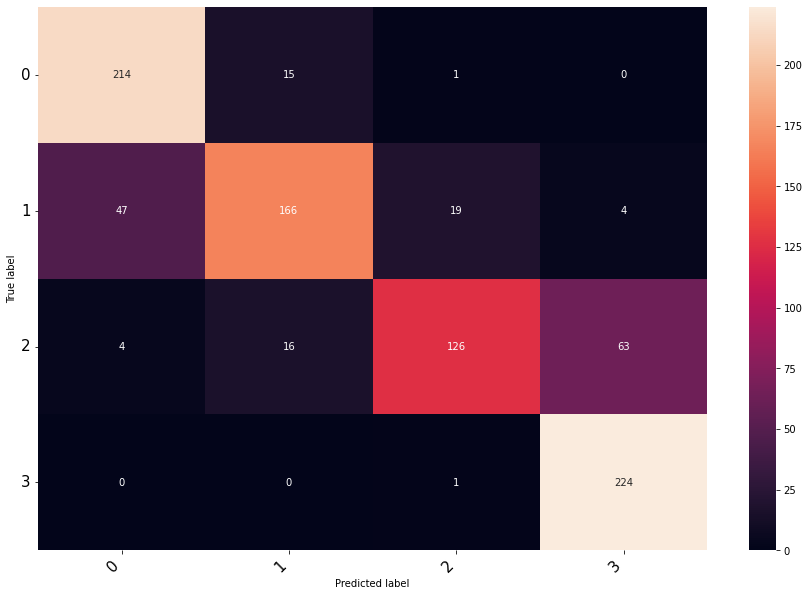

In [30]:
cm.visualize()

In [31]:
cm.class_accuracy

tensor([0.9304, 0.7034, 0.6029, 0.9956])

In [32]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.103127256, 0.11575101, 0.13506429, 0.07454726]

In [33]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.082176074, 0.08975136, 0.09731357, 0.060230587]

#### GraphSAGE Base_n

In [34]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [35]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            base_n=True,
        )

100%|██████████| 144/144 [3:31:08<00:00, 87.98s/it]  


##### Results

In [36]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    base_n=True,
)

toast.show_toast("Done")

100%|██████████| 1188/1188 [07:27<00:00,  2.66it/s]


True

In [37]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.052909233,
 'train_acc': 0.6511111259460449,
 'val_acc': 0.7466666102409363,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0_60',
 'train_rmse': 0.6271629240742259,
 'val_rmse': 0.5033222956847166,
 'test_rmse': 0.590668171555645,
 'train_rmse_perc': 0.13666052,
 'val_rmse_perc': 0.11595097,
 'test_rmse_perc': 0.12712769,
 'train_mcc': 0.5510203810549079,
 'val_mcc': 0.661634765432925,
 'test_mcc': 0.5803567189781141,
 'test_acc': 0.6744444370269775}

In [38]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.052909233,
 'train_acc': 0.6511111259460449,
 'val_acc': 0.7466666102409363,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0_60',
 'train_rmse': 0.6271629240742259,
 'val_rmse': 0.5033222956847166,
 'test_rmse': 0.590668171555645,
 'train_rmse_perc': 0.13666052,
 'val_rmse_perc': 0.11595097,
 'test_rmse_perc': 0.12712769,
 'train_mcc': 0.5510203810549079,
 'val_mcc': 0.661634765432925,
 'test_mcc': 0.5803567189781141,
 'test_acc': 0.6744444370269775}

In [39]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.052909233,
 'train_acc': 0.6511111259460449,
 'val_acc': 0.7466666102409363,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0_60',
 'train_rmse': 0.6271629240742259,
 'val_rmse': 0.5033222956847166,
 'test_rmse': 0.590668171555645,
 'train_rmse_perc': 0.13666052,
 'val_rmse_perc': 0.11595097,
 'test_rmse_perc': 0.12712769,
 'train_mcc': 0.5510203810549079,
 'val_mcc': 0.661634765432925,
 'test_mcc': 0.5803567189781141,
 'test_acc': 0.6744444370269775}

In [40]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1188/1188 [00:00<00:00, 29779.90it/s]


##### cm

In [41]:
cm = all[sort_idx[0]]['test_cm'][0]

In [42]:
(cm.labels==0).sum()

tensor(217)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

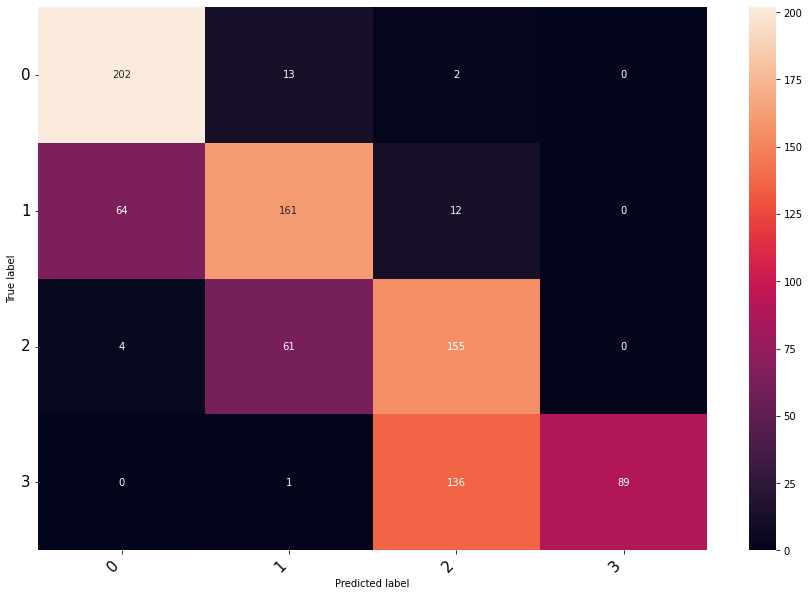

In [43]:
cm.visualize()

In [44]:
cm.class_accuracy

tensor([0.9309, 0.6793, 0.7045, 0.3938])

In [45]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.10038104, 0.113551155, 0.118742704, 0.16564341]

In [46]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.07749608, 0.08652572, 0.09183164, 0.14792289]

### GAT

In [47]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [48]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 288/288 [26:20<00:00,  5.49s/it]


#### Results

In [49]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 3168/3168 [02:45<00:00, 19.09it/s]


In [50]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [15],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.69067603,
 'train_acc': 0.6333333253860474,
 'val_acc': 0.5666666030883789,
 'epoch': 89,
 'model_class': 'gat',
 'path_name': '4_[15]_1_[4_4]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_True_0',
 'train_rmse': 0.6944222218666553,
 'val_rmse': 0.7788880963698616,
 'test_rmse': 0.7272474743090476,
 'train_rmse_perc': 0.15502517,
 'val_rmse_perc': 0.16503333,
 'test_rmse_perc': 0.16239776,
 'train_mcc': 0.5140913672869606,
 'val_mcc': 0.4221839619222784,
 'test_mcc': 0.474920215778847,
 'test_acc': 0.597777783870697}

In [51]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.69067603,
 'train_acc': 0.6333333253860474,
 'val_acc': 0.5666666030883789,
 'epoch': 89,
 'model_class': 'gat',
 'path_name': '4_[15]_1_[4_4]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_True_0',
 'train_rmse': 0.6944222218666553,
 'val_rmse': 0.7788880963698616,
 'test_rmse': 0.7272474743090476,
 'train_rmse_perc': 0.15502517,
 'val_rmse_perc': 0.16503333,
 'test_rmse_perc': 0.16239776,
 'train_mcc': 0.5140913672869606,
 'val_mcc': 0.4221839619222784,
 'test_mcc': 0.474920215778847,
 'test_acc': 0.597777783870697}

In [52]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.74343157,
 'train_acc': 0.6111111044883728,
 'val_acc': 0.5799999237060547,
 'epoch': 80,
 'model_class': 'gat',
 'path_name': '4_[20]_1_[4_4]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_True_0_80',
 'train_rmse': 0.7731609003162134,
 'val_rmse': 0.7571877794400365,
 'test_rmse': 0.8041558721209878,
 'train_rmse_perc': 0.16866907,
 'val_rmse_perc': 0.17660601,
 'test_rmse_perc': 0.17804283,
 'train_mcc': 0.4817360768841294,
 'val_mcc': 0.43249047844092925,
 'test_mcc': 0.43043855057573577,
 'test_acc': 0.5711110830307007}

In [53]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 3168/3168 [00:00<00:00, 22852.45it/s]
